# Projekt zaliczeniowy- Małgorzata Pieronek
*Studia podyplomowe: Data Science: zaawansowana analiza danych*

## Temat: Analiza czynników wpływających na założenie lokaty terminowej z wykorzystaniem drzew decyzyjnych

**1. Cel i zakres analizy**

Celem niniejszej pracy jest analiza czynników wpływających na podjęcie decyzji o założeniu lokaty terminowej, w wyniku kampanii marketingowej, polegającej na wykonywaniu rozmów telefonicznych przez jeden z portugalskich banków.
    Analiza będzie obejmowała zastosowanie drzewa decyzyjnego. 
    Do analizy użyto metodologii CRISP-DM, która składa się z 6 etapów. Pierwszym z nich jest zrozumienie problemu biznesowego, który ma swoje odzwierciedlenie w danych. Drugi krok to eksploracja danych polegająca na wstępnej ocenie jakości danych i występujących pomiędzy nimi zależności. Kolejny to modyfikacja danych, służąca przygotowaniu ich do modelu, w tym kroku wykonuje się m.in. standaryzację zmiennych i ich podział na zbiór treningowy i testowy. Po wykonaniu tych czynności można przystąpić do modelowania za pomocą wybranych modeli. Ostatnią czynnością przed wdrożeniem jest ewaluacja, czyli ocena jakości zbudowanych modeli i wybór najlepszego z nich. 
    
Celem tego modelu będzie zbudowanie drzewa decyzyjnego które będzie modelowało skłonność do założenia lokaty terminowej w zależności od wartości poszczególnych zmiennych.

**2.	Opis zbioru danych**

Dane pochodzą ze strony internetowej Center for Machine Learning and Intelligent Systems Uniwersytetu Kalifornijskiego w Irvinie (https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Dotyczą skłonności do zakładania lokaty terminowej w jednym z portugalskich banków w zależności od poszczególnych czynników, które zostały poniżej wymienione i są jednocześnie zmiennymi objaśniającymi w modelu. Zbiór zawiera 45211 obserwacji i 15 zmiennych.
Zmienna objaśniana (celu) przyjmuje dwie wartości: tak (5289 klientów) - jeśli klient zdecydował się na założenie lokaty terminowej lub nie (39 922 klientów) - jeśli nie podjął takiej decyzji.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [5]:
bank = pd.read_csv("bank-full.csv", sep=';')

W zbiorze znajduje się 15 zmiennych: 

**Binarne:**
1. *Default:* Czy klient kiedykolwiek nie wywiązał się ze zobowiązania kredytowego
2. *Housing:* Czy klient posiada kredyt mieszkaniowy
3. *Loan:* Czy klient posiada kredyt gotówkowy
4. *Subscribe a term deposit (term deposit):* Czy klient założył lokatę terminową: 1-sukces, 0-porażka

**Numeryczne:**
5. *Age:* Wiek klienta
6. *Campaign:* Liczba kontaktów nawiązanych z klientem podczas danej kampanii
7. *Duration:* Czas trwania ostatniego kontaktu (w sekundach)
8. *Pdays:* Liczba dni, które minęły od ostatniego kontaktu  
9. *Previous:* Liczba kontaktów z danym konsumentem, które miały miejsce przed kampania marketingową

**Nominalne:**
10. *Contact:* Rodzaj kontaktu
11. *Education:* Wykształcenie klienta
12. *Job:* Rodzaj pracy wykonywany przez klienta
13. *Marital:* Stan cywilny
14. *Month:* Miesiąc, w którym ostatnio kontaktowano się z klientem
15. *Poutcome:* Wynik poprzedniej kampanii marketingowej: 1-sukces, 0-porażka

In [6]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,subscribe a term deposit
0,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,no


In [7]:
#zmienna "subscribe a term deposit" zostanie nazwana krócej: term_deposit
bank.rename(columns={"subscribe a term deposit": "term_deposit"}, inplace=True)

W zbiorze znajdują się klienci w wieku 18 do 95 lat, a średnia ich wieku wynosi 41 lat. 

In [8]:
bank.describe()

,age,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,258.163080,2.763841,40.197828,0.580323
std,10.618762,257.527812,3.098021,100.128746,2.303441
min,18.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,4918.000000,63.000000,871.000000,275.000000


Zmienna 'pdays' przyjmuje wartosc -1 w przypadku braku danych, ponieważ dla 36 954 oberwacji występują braki danych, to zmienna ta nie będzie użyta w modelu. Przed przystąpieniem do budowy drzewa decyzyjnego usunięcie braków danych nie jest konieczne, jednak zmienna która zawiera blisko 82% braków danych nie wnosi znaczącego zysku informacyjnego.

In [9]:
bank['pdays'].value_counts().head(5)

-1      36954
 182      167
 92       147
 183      126
 91       126
Name: pdays, dtype: int64

In [10]:
bank['term_deposit'].value_counts().head(5)

no     39922
yes     5289
Name: term_deposit, dtype: int64

Zmienna 'job' przyjmuje 13 rożnych wartości, konieczne wydaje się pogrupowanie tych danych aby ograniczyć liczbę kategorii, jednak ze względu na brak wystarczającej wiedzy eksperckiej dotyczącej informacji które grupy zawodowe są do siebie najbardziej zbliżone ze względu na skłonność do zawierania pożyczek, zmienna ta zostanie pominięta.

In [11]:
bank['job'].sort_values().unique()

array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'], dtype=object)

Ze względu na liczne braki danych dotyczące informacji o rodzaju kontaktu z klientem zmienna nie zostanie użyta w modelu. Taka sama decyzja została podjęta odnośnie zmiennej 'poutcome'.

In [12]:
bank['contact'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [13]:
bank['contact'].value_counts().head(5)  #13020 braków danych

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [14]:
bank['poutcome'].unique() 

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [15]:
bank['poutcome'].value_counts().head(5) 

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [16]:
bank['education'].sort_values().unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

W przypadku zmiennej 'education' również występują braki danych jednak dotyczą one jedynie ok.4% obserwacji, a więc zmienna utrzymuje swoją zdolność dyskryminacyjną. Zmienna zostanie włączona do modelu, w przypadku drzewa decyzyjnego braki danych nie stanowią przeszkody, jest to jedna z zalet tego typu modelu.

In [17]:
bank[bank.education=='unknown'].count()  #1857 braków danych

age             1857
job             1857
marital         1857
education       1857
default         1857
housing         1857
loan            1857
contact         1857
month           1857
duration        1857
campaign        1857
pdays           1857
previous        1857
poutcome        1857
term_deposit    1857
dtype: int64

W przypadku stanu cywilnego nie występują braki danych.

In [18]:
bank['marital'].unique() 

array(['married', 'single', 'divorced'], dtype=object)

Zmienna 'month' nie zostanie włączona do modelu, ponieważ informuje ona o miesiącu w którym został wykonany ostatni kontakt. Bazując na wiedzy eksperckiej wiemy, że zmienna ta nie ma znaczącego wpływu na skłonność do założenia lokaty terminowej.

Analizując wykres zmiennej 'default' mówiącą o tym, że w przeszłości klient miał problemy ze spłatą kredytu można zauważyć, że prawie wszyscy klienci którzy znajdują się w zbiorze nie mieli dotychczasowych problemów ze spłatą kredytu.

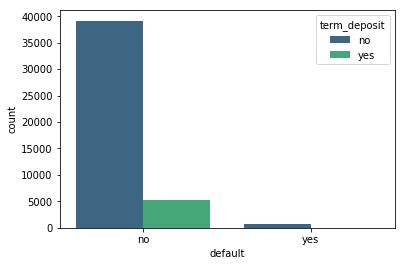

In [19]:
sns.countplot(x='default',data=bank,palette='viridis', hue='term_deposit')

Wśród analizowanych klientów zadecydowanie ponad połowa ma kredyt hipoteczny. Wśród osób z kredytem mieszkaniowym znajduje się mniejszy odsetek osób z lokatą terminową aniżeli w grupie bez tego typu kredytu.

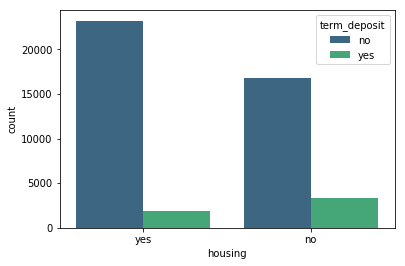

In [20]:
sns.countplot(x='housing',data=bank,palette='viridis', hue='term_deposit')

Wśród osób z kredytem gotówkowym nikły odsetek posiada lokatę terminową. Co świadczy o tym że zmienna ta może w dobry sposób dyksryminować zbiór klientów.

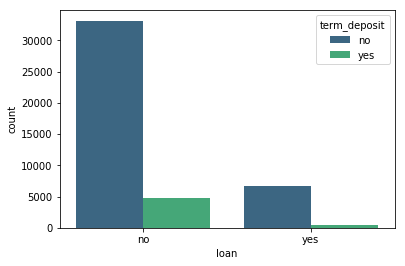

In [21]:
sns.countplot(x='loan',data=bank,palette='viridis', hue='term_deposit')

Zmienne binarne zostaną przekodowane na zmienne liczbowe. 'No' przyjmie wartość 0 z kolei 'Yes' wartość 1.

In [22]:
bank['term_deposit'].replace({'no': 0, 'yes': 1}, inplace=True)

In [23]:
bank['default'].replace({'no': 0, 'yes': 1}, inplace=True)

In [24]:
bank['housing'].replace({'no': 0, 'yes': 1}, inplace=True)

In [25]:
bank['loan'].replace({'no': 0, 'yes': 1}, inplace=True)

Ważnym elementem eksploracji danych jest ich wizualizacja, zmienne numeryczne zostaną przedstawione za pomocą histogramów.
Większość klientów jest w wieku 20 do 60 lat, największy udział w tej grupie stanowią trzydziestoparolatkowie.

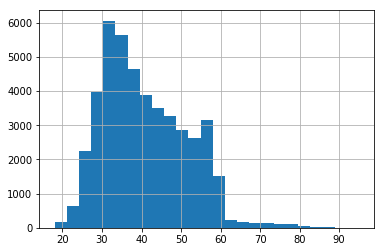

In [26]:
bank['age'].hist(bins=25)

Wartości zmiennej 'liczba kontaktów nawiązanych z klientem podczas danej kampanii' ma silnie prawoskośny rozkład, podobnie jak zmienna 'czas trwania ostatniego kontaktu'.

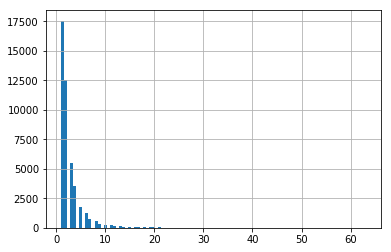

In [27]:
bank['campaign'].hist(bins=100)

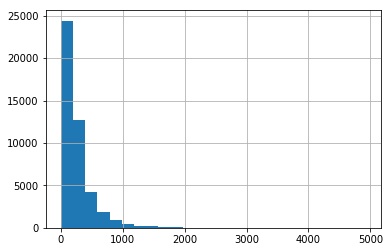

In [28]:
bank['duration'].hist(bins=25)

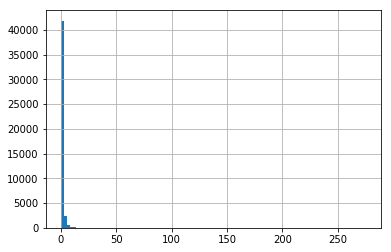

In [29]:
bank['previous'].hist(bins=100)

Występuje wysoka korelacja pomiędzy zmiennymi 'pdays' i 'previous' więc nie mogą obie znaleźć się w modelu. Ale na wstępnym etapie analizy odrzucona została zmienna 'pdays' ze względu na braki danych, więc problem skorelowania nie będzie występował- do modelu włączona zostanie zmienna 'previous'. Współczynniki korelacji między pozostałymi zmiennymi są na akceptowalnym poziomie.

In [30]:
corr=bank.corr()
corr

,age,default,housing,loan,duration,campaign,pdays,previous,term_deposit
age,1.000000,-0.017879,-0.185513,-0.015655,-0.004648,0.004760,-0.023758,0.001288,0.025155
default,-0.017879,1.000000,-0.006025,0.077234,-0.010021,0.016822,-0.029979,-0.018329,-0.022419
housing,-0.185513,-0.006025,1.000000,0.041323,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,0.077234,0.041323,1.000000,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
duration,-0.004648,-0.010021,0.005075,-0.012412,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,0.016822,-0.023599,0.009980,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,-0.029979,0.124178,-0.022754,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,-0.018329,0.037076,-0.011043,0.001203,-0.032855,0.454820,1.000000,0.093236
term_deposit,0.025155,-0.022419,-0.139173,-0.068185,0.394521,-0.073172,0.103621,0.093236,1.000000


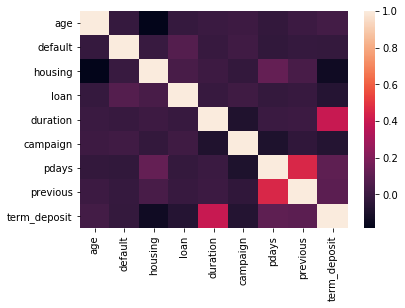

In [31]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Przed włączeniem zmiennych do modelu zbadany zostanie współczynnik zmienności każdej zmiennej ciągłej. Jest to miara wskazująca na stosunek odchylenia standardowego do średniej. Przyjmuje się, że jego wartość powinna przekraczać 10%.

Wartości dla każdej zmiennej znacznie przekraczają 10% co oznacza, że ze względu na tę miarę żadna zmienna nie powinna zostać pominięta w modelu.

In [32]:
ile= np.std(bank['age']) / np.mean(bank['age'])
ile
print("{:3.2f}%".format(ile*100))

25.94%


In [33]:
ile= np.std(bank['campaign']) / np.mean(bank['campaign'])
ile
print("{:3.2f}%".format(ile*100))

112.09%


In [34]:
ile= np.std(bank['duration']) / np.mean(bank['duration'])
ile
print("{:3.2f}%".format(ile*100))

99.75%


In [35]:
ile= np.std(bank['previous']) / np.mean(bank['previous'])
ile
print("{:3.2f}%".format(ile*100))

396.92%


**3. Podział zbioru danych**

W kolejnym kroku następuje podział na zmienne zależne i niezależne.

In [36]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,0,1,0,unknown,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,1,0,unknown,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,1,1,unknown,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1,0,unknown,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,0,0,unknown,may,198,1,-1,0,unknown,0


In [37]:
X = bank[['default', 'housing', 'loan','age', 'campaign', 'duration','previous', 'education', 'contact', 'marital', 
          'poutcome']]
y = bank[['term_deposit']]

Zmienne tekstowe zamienione zostają na zmienne binarne.

In [38]:
X = pd.get_dummies(X)
X.head(3)

,default,housing,loan,age,campaign,duration,previous,education_primary,education_secondary,education_tertiary,...,contact_cellular,contact_telephone,contact_unknown,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,1,0,58,1,261,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,1,0,44,1,151,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
2,0,1,1,33,1,76,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1


W budowaniu modeli machine learningowych konieczne jest podzielenie zbioru danych na dane treningowe i testowe. Jest to konieczne w celu weryfikacji jakości modelu (sprawdzenia mocy predykcyjnej na nowym zestawie danych).

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

In [40]:
X.head()

,default,housing,loan,age,campaign,duration,previous,education_primary,education_secondary,education_tertiary,...,contact_cellular,contact_telephone,contact_unknown,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,1,0,58,1,261,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,1,0,44,1,151,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
2,0,1,1,33,1,76,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,0,47,1,92,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4,0,0,0,33,1,198,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [41]:
y.head()

,term_deposit
0,0
1,0
2,0
3,0
4,0


In [42]:
X_train.shape

(31647, 21)

In [43]:
X_test.shape

(13564, 21)

In [44]:
y_train.shape

(31647, 1)

In [45]:
y_test.shape

(13564, 1)

Nadreprezentacja jednej z klas może skutkować przesunięciem oszacowań w stronę grupy liczniejszej. Aby zapobiec temu na etapie przygotowywania danych należy zastosować jedną z metod która temu zapobiegnie. W tym przypadku zastosujemy 'oversampling', który polega na wyrównaniu w próbie proporcji między obiema klasami, nadpróbkowując klasę mniej liczną- ale wykonuje się to jedynie na zbiorze treningowym.

In [46]:
from sklearn.utils import resample

# ponowne złączenie danych treningowych
X = pd.concat([X_train, y_train], axis=1)

# podzial na klasy 
nie_ma_lokaty = X[X.term_deposit==0]
ma_lokate = X[X.term_deposit==1]

# oversampling grupy mniej licznej
lokata_upsampled = resample(ma_lokate,
                          replace=True, # sample with replacement
                          n_samples=len(nie_ma_lokaty), # match number in majority class
                          random_state=111) # reproducible results


In [47]:
upsampled = pd.concat([nie_ma_lokaty, lokata_upsampled])

In [48]:
upsampled.term_deposit.value_counts()

1    27936
0    27936
Name: term_deposit, dtype: int64

In [49]:
# ponowny podział na zmienne zależne i niezależne zbioru po oversamplingu
X_train = upsampled.drop('term_deposit', axis=1)
y_train = upsampled.term_deposit

**4. Budowa drzewa decyzyjnego**

Drzewo decyzyjne zbudowane będzie przy parametrach domyślnych.

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
dtree = DecisionTreeClassifier( )

In [52]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
predictions = dtree.predict(X_test)

In [54]:
from sklearn.metrics import classification_report,confusion_matrix

In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11986
           1       0.39      0.38      0.38      1578

   micro avg       0.86      0.86      0.86     13564
   macro avg       0.65      0.65      0.65     13564
weighted avg       0.86      0.86      0.86     13564



In [56]:
print(confusion_matrix(y_test,predictions))

[[11054   932]
 [  983   595]]


**5.Weryfikacja modelu**

Jakość otrzymanego modelu na ustawieniach domyślnych jest niezadowalająca (można to wywnioskować na podstawie miar precision i recall), więc warto spróbować poszukać rozwiązania jeszcze lepszego stosując funkcję GridSearch. Poszukuje ona optymalnego rozwiązania spośród podanych parametrów.

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

params_grid = {
    'max_depth': [ 3, 5, 7,9,11], 
    'min_samples_split': [5, 10,15], 
    'min_samples_leaf': [4, 5, 6,15,20], 
}

tree = GridSearchCV(dtree, params_grid, cv=3)

tree.fit(X_train, y_train)
predictions = dtree.predict(X_test)



In [59]:
tree.best_params_


{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5}

W dalszej części zbuduję drzewo decyzyjne o parametrach zgodnych z powyższym wynikiem (który jest efektem zastosowania metody GridSearch). Do oceny jakości modelu posłuży macierz pomyłek i na jej podstawie wynegerowane wartości dopasowania modelu do danych: precision, recall, f1-score.

In [60]:
dtree_best = DecisionTreeClassifier(max_depth=11, min_samples_split=5, min_samples_leaf=4  )

In [61]:
dtree_best.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [62]:
predictions_best = dtree_best.predict(X_test)

In [63]:
print(classification_report(y_test,predictions_best))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     11986
           1       0.36      0.78      0.49      1578

   micro avg       0.81      0.81      0.81     13564
   macro avg       0.66      0.80      0.69     13564
weighted avg       0.90      0.81      0.84     13564



In [64]:
print(confusion_matrix(y_test,predictions_best))

[[9790 2196]
 [ 341 1237]]


**6. Wnioski**

Wartość 'precision' mówi  o tym jaki jaka część wyników wskazanych przez klasyfikator jako dodatnie jest rzeczywiście dodatnia. Z kolei 'recall' ocenia jaką część dodatnich wyników wykrył klasyfikator. Z kolei F1-score jest interpretowany jako ważona średnia precyzji i czułości. Drzewo decyzyjne o głębokości 11, minimalnym podziale drzewa dla węzła 5 elementowego i minimalnej liczebności liścia wynoszącej 4 osiąga generalnie lepsze wartości miar trafności aniżeli drzewo o minimalnym podziale drzewa dla węzła 2 elementowego i minimalnej liczebności liścia wynoszącej 1  i bez górnej granicy głębokości. Aby zbadać czy między modelami istnieje istotna statystycznie różnica należałoby w tym celu wykonać jeden z testów: t-test różnicy średnich metryk, test McNemara, test Wilcoxona. 

Analizując otrzymane wyniki dla modelu z najlepszymi parametrami (spośród podanych możliwości) stwierdzić można, że model niezwykle dokładnie klasyfikuje niezałożenie lokaty terminowej. Wśród wszystkich wykrytych przez model przypadków niezałożenia lokaty aż 97% rzeczywiście dotyczyło przypadków niezałożenia lokaty. Z kolei 82% wszystkich niezałożeń lokaty jest wykrywane przez model. 

Model gorzej sobie radzi w przypadku wykrywania klientów ze spłatą lokaty terminowej, jedynie 36% przypadków ocenionych przez model jako założenie lokaty została zaklasyfikowana poprawnie. Jednak pod względem wykrywalności wszystkich przypadków założeń lokaty model wykrył aż 78% przypadków co jest wynikiem zadowalającym.